# Libraries

In [46]:
import h5py
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics  import r2_score
from glob             import glob

import matplotlib.pyplot as plt
import scipy.signal      as signal
import torch.nn          as nn
import numpy  			 as np
import pandas 		     as pd


# ECG Definitions

ECG metadata

In [4]:
samplingFrequency = 400

ECG file headers

In [ ]:
ecgHeaders = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [ ]:
ecgPlotHeaders = [
	"LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

# The Dataset: CODE-15

Metadata

In [7]:
dataFolder = "../../../data/CODE15/hdf5/"

In [8]:
ecgFeatures = [
	"LI", 
	"aVF", 
	"V2"
]

ecgFeaturesIndexes = [ecgHeaders.index(derivation) for derivation in ecgFeatures]
ecgFeaturesIndexes

[0, 5, 7]

In [9]:
ecgTarget = [
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"V1",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgTargetIndexes = [ecgHeaders.index(derivation) for derivation in ecgTarget]
ecgTargetIndexes

[1, 2, 3, 4, 6, 8, 9, 10, 11]

Dataset class

In [ ]:
class Code15Dataset(Dataset):
	def __init__(self, hdf5Files, features, target, transform):
		
		super().__init__()
		
		self.hdf5Files = hdf5Files
		self.indexMap  = []
		self.features  = features
		self.target    = target
		self.transform = transform


		for fileIndex, path in enumerate(self.hdf5Files):
			
			with h5py.File(path, "r") as f:
				samplesCount = f['exam_id'].shape[0]
				
				self.indexMap.extend([(fileIndex, i) for i in range(samplesCount)])

	def __len__(self):
		return len(self.indexMap)

	def __getitem__(self, idx):

		fileIndex, examIdx = self.indexMap[idx]
		hdf5File           = self.hdf5Files[fileIndex]

		with h5py.File(hdf5File, "r") as file:
			tracing = np.array(file['tracings'][examIdx])

		tracing = self.transform(tracing)

		X = tracing[:, self.features]
		X = torch.tensor(X, dtype = torch.float32)

		Y = tracing[:, self.target]
		Y = torch.tensor(Y, dtype = torch.float32)

		return X, Y


Transform Function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $ N = 600  $ samples
- Gain of 5
- Normalization with z-score

In [ ]:
def transform(ecg):
	b, a = signal.butter(
		N     = 1, 
		Wn    = 1, 
		btype = 'high', 
		fs    = samplingFrequency
	)
	
	ecgFiltred  = signal.filtfilt(b, a, ecg, axis = 0)
	ecgWithGain = 5 * ecgFiltred
	ecgClean    = ecgWithGain[600: -600, :]

	ecgMean = np.mean(ecgClean, axis = 0, keepdims = True)
	ecgStd  = np.std(ecgClean,  axis = 0, keepdims = True) + 1e-8

	ecgNormalized = (ecgClean - ecgMean) / ecgStd

	return ecgNormalized


Holdout dataset

In [ ]:
dataset = Code15Dataset(
	hdf5Files = glob(f"{dataFolder}/*.hdf5")[:-9],
	features  = ecgFeaturesIndexes,
	target    = ecgTargetIndexes,	
	transform = transform
)

In [13]:
len(dataset)

20001

In [14]:
generator = torch.Generator().manual_seed(14)

In [15]:
trainRatio = 0.80

trainSize = int(trainRatio * len(dataset))
testSize  = len(dataset) - trainSize

print("Train dataset Len =", trainSize)
print("Train dataset Len =", testSize)

Train dataset Len = 16000
Train dataset Len = 4001


In [32]:
trainDataset, testDataset = random_split(
	dataset = dataset,
	lengths = [trainSize, testSize]
)

Dataloaders

In [33]:
trainDataloader = DataLoader(
	dataset     = trainDataset,
	batch_size  = 32,
	shuffle     = True,
	num_workers = 4

)

testDataloader = DataLoader(
	dataset     = testDataset,
	batch_size  = 32,
	shuffle     = False,
	num_workers = 4

)

# Model definition

In [ ]:
class ECGReconstructor(nn.Module):
	def __init__(self):
		super().__init__()

		self.linear = nn.Linear(
			in_features  = 3,
			out_features = 9
		)

	def forward(self, X):
		return self.linear(X)

# Training

Metadata

In [ ]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = ECGReconstructor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()
epochs    = 10

print(device)

cuda


Run

In [20]:
trainingLoss = []

In [ ]:
model.train()

for epoch in range(epochs):
	totalLoss = 0

	for X, Y in trainDataloader:
		X, Y = X.to(device), Y.to(device)

		prediction = model(X)
		loss       = criterion(prediction, Y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		totalLoss += loss.item()

	trainingLoss.append(totalLoss / len(trainDataloader))

	print(f"Epoch {epoch + 1}: loss = {trainingLoss[-1]:.4f}")

Epoch 1: loss = 0.8808
Epoch 2: loss = 0.3921
Epoch 3: loss = 0.2857
Epoch 4: loss = 0.2559
Epoch 5: loss = 0.2489
Epoch 6: loss = 0.2478
Epoch 7: loss = 0.2477
Epoch 8: loss = 0.2477
Epoch 9: loss = 0.2477
Epoch 10: loss = 0.2477
Epoch 11: loss = 0.2477
Epoch 12: loss = 0.2477
Epoch 13: loss = 0.2477
Epoch 14: loss = 0.2477
Epoch 15: loss = 0.2477
Epoch 16: loss = 0.2477
Epoch 17: loss = 0.2477
Epoch 18: loss = 0.2477
Epoch 19: loss = 0.2477
Epoch 20: loss = 0.2477
Epoch 21: loss = 0.2477
Epoch 22: loss = 0.2477
Epoch 23: loss = 0.2477
Epoch 24: loss = 0.2477
Epoch 25: loss = 0.2477
Epoch 26: loss = 0.2477
Epoch 27: loss = 0.2477
Epoch 28: loss = 0.2478
Epoch 29: loss = 0.2477
Epoch 30: loss = 0.2477


Loss along the epochs

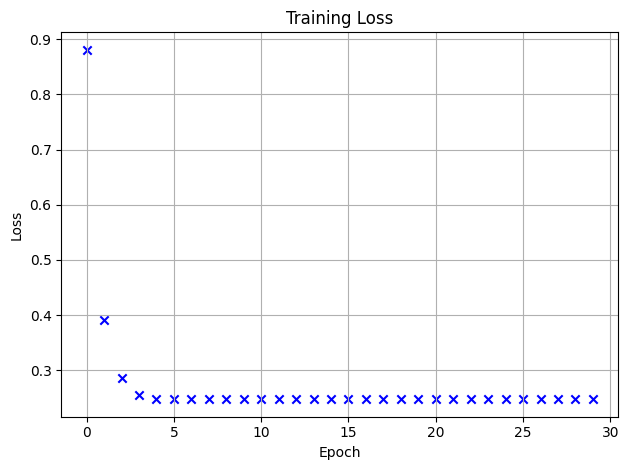

In [22]:
plt.scatter(range(epochs), trainingLoss, c = "blue", marker = "x")

plt.title("Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid()
plt.tight_layout()
plt.show()

# Test

In [40]:
model.eval()

testLoss = 0
testR2   = 0

totalSamples = 0

with torch.no_grad():
	for X, Y in testDataloader:
		X, Y       =  X.to(device), Y.to(device)
		prediction =  model(X)
		loss       =  criterion(prediction, Y)
		testLoss   += loss.item()

		YFlat 		   = Y.cpu().numpy().reshape(-1, Y.shape[-1])
		predictionFlat = prediction.cpu().numpy().reshape(-1, prediction.shape[-1])

		testR2 += r2_score(YFlat, predictionFlat) * YFlat.shape[0]

		totalSamples += YFlat.shape[0]

testR2 /= totalSamples

print(f"Test Loss: {testLoss:.4f}")
print(f"Test R^2:  {testR2:.4f}")


Test Loss: 30.5327
Test R^2:  0.7562


# Ploting

Ploting functions

In [56]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [94]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75
		)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha = 0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} r2 = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

Extract a sample ECG from dataset

In [95]:
sampleECGFeaturesTensor, sampleECGTargetTensor = dataset[32]

sampleECGFeatures = pd.DataFrame(
    columns = ecgFeatures,
    data    = sampleECGFeaturesTensor
)

sampleECGTarget = pd.DataFrame(
    columns = ecgTarget,
    data    = sampleECGTargetTensor
)

sampleECG = pd.concat(
    [sampleECGFeatures, sampleECGTarget],
    axis = 'columns'
)

sampleECG.head()


,LI,aVF,V2,LII,LIII,aVR,aVL,V1,V3,V4,V5,V6
0,-0.298292,-0.162364,-0.061621,-0.301953,0.089561,0.306154,-0.229197,0.499286,-0.077974,-0.116472,-1.662887,0.032942
1,-0.391689,-0.153561,-0.060087,-0.336523,0.194455,0.396870,-0.333652,0.499421,-0.075353,-0.116203,-1.634202,0.042673
2,-0.460769,-0.172363,-0.063119,-0.379945,0.249162,0.450773,-0.421214,0.442731,-0.087725,-0.122040,-1.615626,0.018341
3,-0.506925,-0.158735,-0.060091,-0.412026,0.281781,0.481854,-0.485428,0.403982,-0.098776,-0.113954,-1.589664,0.002749
4,-0.523488,-0.171819,-0.060715,-0.448528,0.261466,0.530101,-0.482964,0.407905,-0.093453,-0.112289,-1.557968,0.045672


In [96]:
with torch.no_grad():
    sampleECGPredicted = model(sampleECGFeaturesTensor.to(device)).cpu().numpy()

sampleECGPredicted = pd.DataFrame(
	columns = ecgTarget,
	data    = sampleECGPredicted
)

sampleECGReconstructed = pd.concat(
    [sampleECGFeatures, sampleECGPredicted],
	axis = 'columns'
)

sampleECGReconstructed.head()

,LI,aVF,V2,LII,LIII,aVR,aVL,V1,V3,V4,V5,V6
0,-0.298292,-0.162364,-0.061621,-0.246806,0.008616,0.284906,-0.205244,0.147555,-0.124401,-0.222227,-0.254011,-0.254027
1,-0.391689,-0.153561,-0.060087,-0.284150,0.064957,0.354605,-0.295957,0.199615,-0.133742,-0.261821,-0.309205,-0.314542
2,-0.460769,-0.172363,-0.063119,-0.328763,0.083553,0.414587,-0.351390,0.238242,-0.149575,-0.301908,-0.359625,-0.367319
3,-0.506925,-0.158735,-0.060091,-0.340996,0.119805,0.445966,-0.400425,0.264340,-0.150341,-0.317209,-0.383267,-0.394277
4,-0.523488,-0.171819,-0.060715,-0.357465,0.116346,0.463253,-0.409623,0.274487,-0.155981,-0.329857,-0.398371,-0.409631


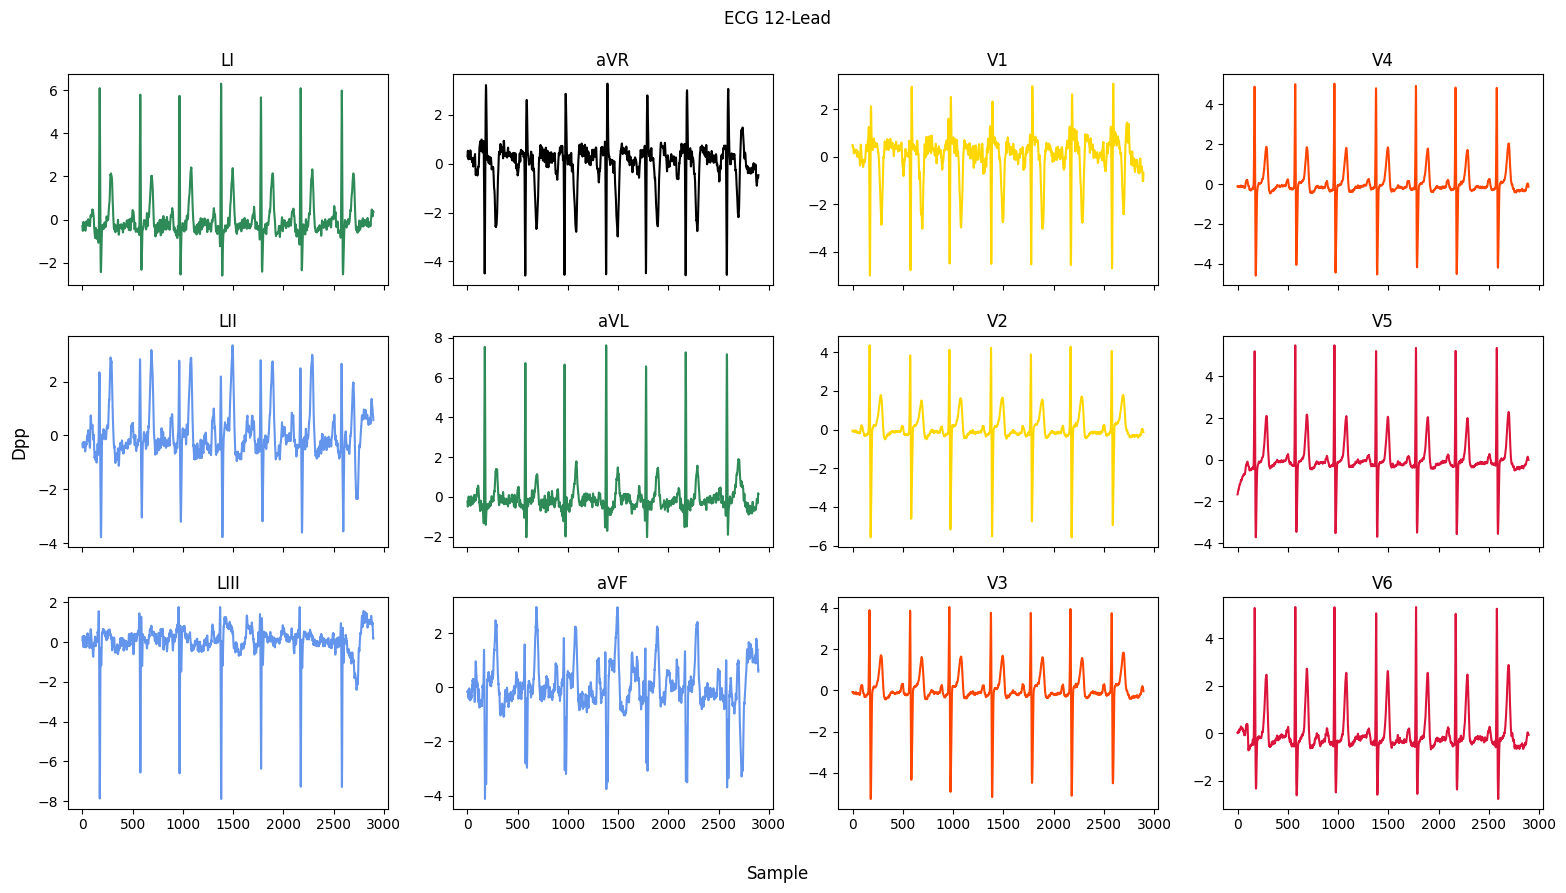

In [97]:
plotECG(
    ecg     = sampleECG,
    headers = ecgPlotHeaders,
    colors  = ecgPlotColors
)

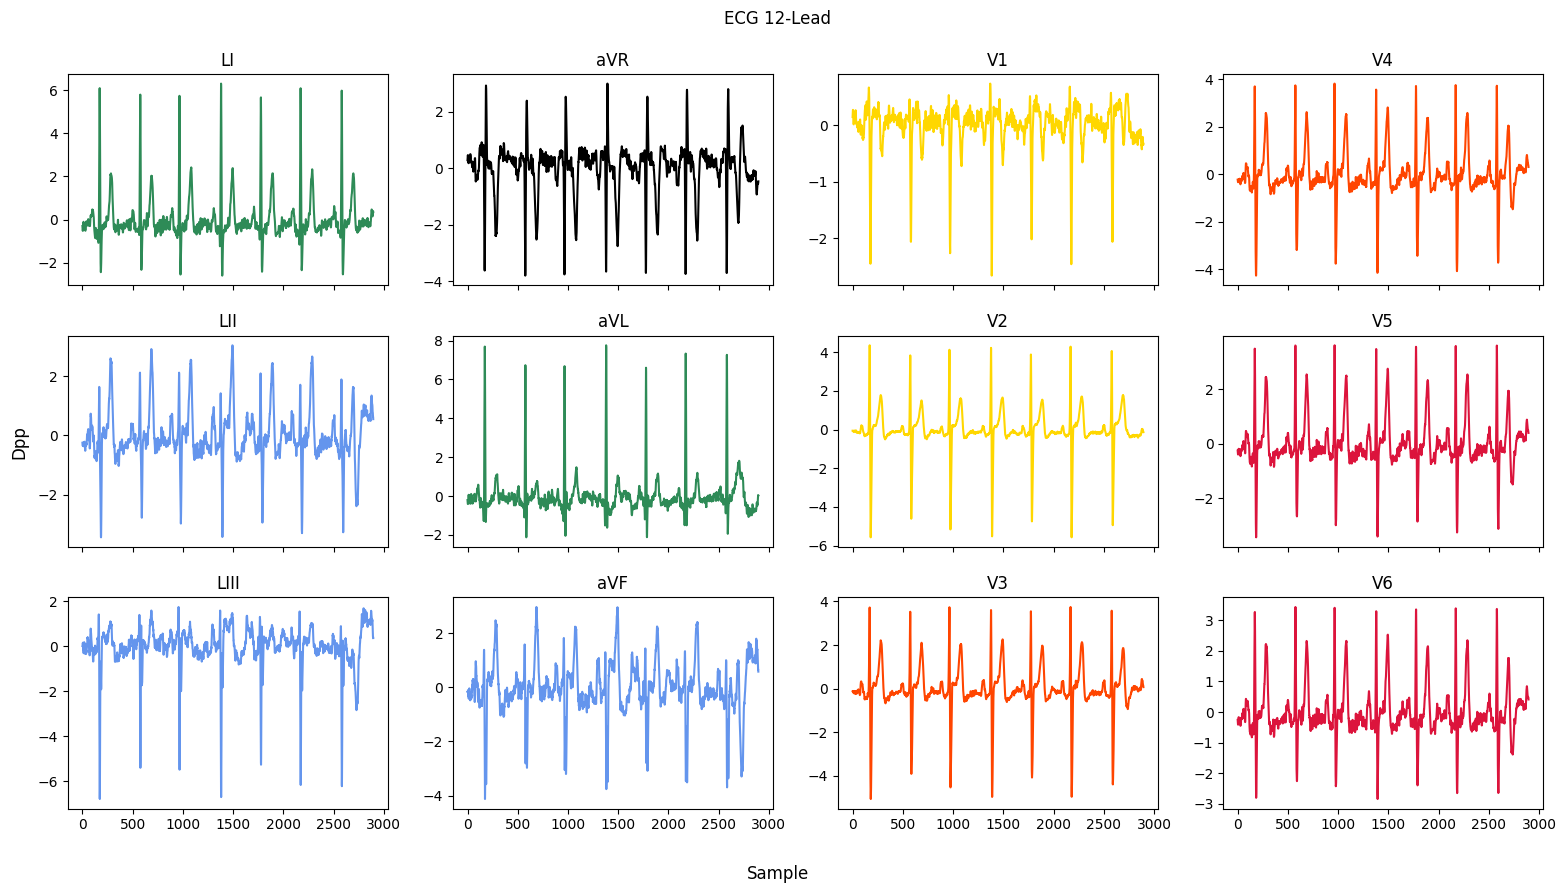

In [98]:
plotECG(
    ecg     = sampleECGReconstructed,
    headers = ecgPlotHeaders,
    colors  = ecgPlotColors
)

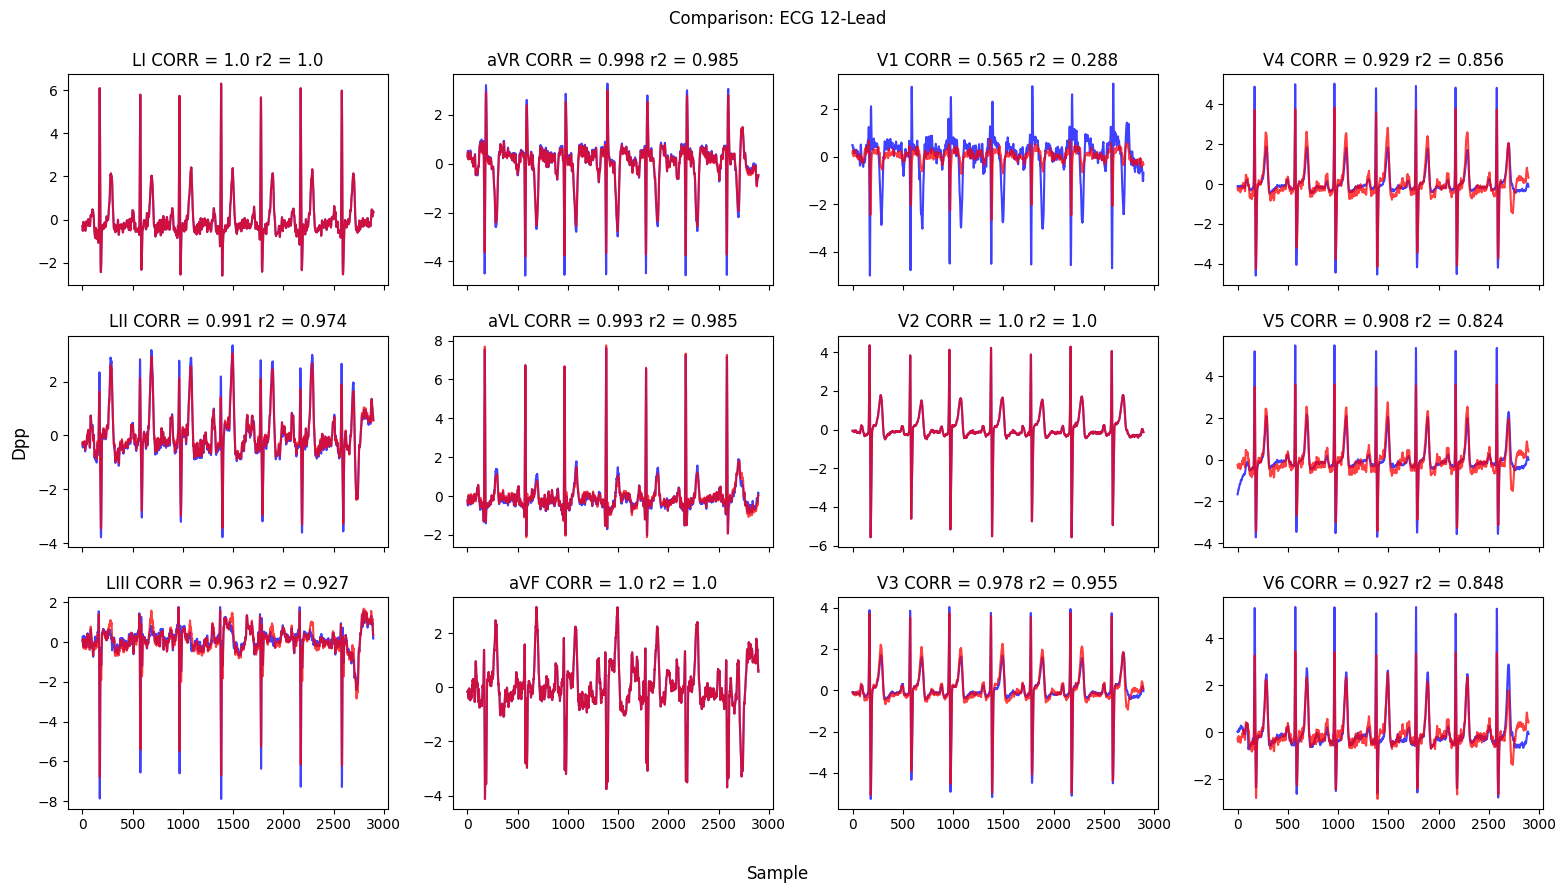

In [99]:
comparativeFullEcgPlot(
	ecgOring = sampleECG,
	ecgRec   = sampleECGReconstructed,
	headers  = ecgPlotHeaders
)

In [100]:
viewWindow = slice(1000, 2000)

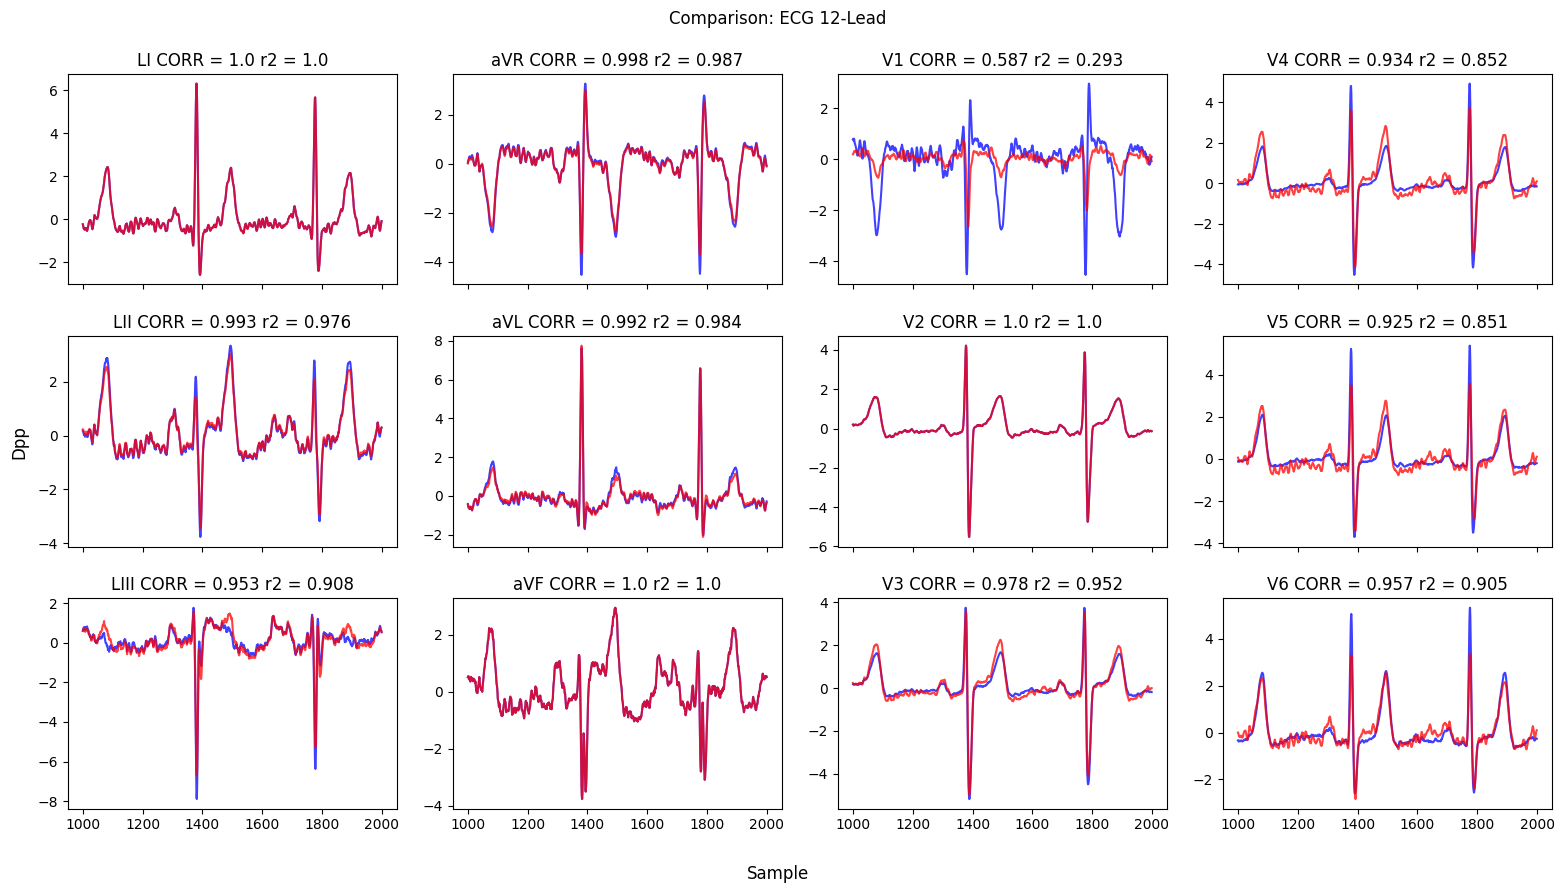

In [101]:
comparativeFullEcgPlot(
	ecgOring = sampleECG[viewWindow],
	ecgRec   = sampleECGReconstructed[viewWindow],
	headers  = ecgPlotHeaders
)

# Save model

In [102]:
torch.save(model.state_dict(), "../../../models/t0/reglin-t0-v1.pth")